In [1]:
# Imports
import numpy as np
import squigglepy as sq
from squigglepy.numbers import K, M, B, T
from squigglepy import bayes
import matplotlib.pyplot as plt
from pprint import pprint


def hist(samples, title=None, bins=200):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist(samples, bins=bins)
    if title is not None:
        plt.title(title)
    return plt.show()


print('Loaded')

Loaded


In [2]:
def chance_of_death_from_covid(age, gender='male', copd=False, immune_compromised=False, diabetic=False, treatments=True):
    """
    Calculation based on equation from https://twitter.com/DFisman/status/1273266048570138625 adjusted
    for CFR->IFR using age-based weights derived from https://www.medrxiv.org/content/10.1101/2020.07.23.20160895v2
    Omicron reduction from https://www.metaculus.com/questions/8766/omicron-variant-less-deadly-than-delta/
    """
    
    gender = 2 if gender.lower() == 'male' else 0
    copd = 3 if copd else 0
    immune_compromised = 4 if immune_compromised else 0
    diabetic = 4 if diabetic else 0
    treatments = 0.2 if treatments else 1
    
    if age < 50:
        adj_age = 10
    elif age < 60:
        adj_age = 8
    elif age < 70:
        adj_age = 4.5
    elif age < 80:
        adj_age = 3.5
    else:
        adj_age = 1
        
    omicron_reduction = 0.94
    
    p = 1 / ((np.exp(9.99 - 0.34 * ((age*3)/10 + gender + copd + immune_compromised + diabetic)) + 1) * adj_age)
    return p * omicron_reduction * treatments
    

print('29yo male, no COPD/immune/diabetic: {}'.format(sq.one_in(chance_of_death_from_covid(29,
                                                                                           gender='male',
                                                                                           copd=False,
                                                                                           immune_compromised=False,
                                                                                           diabetic=False,
                                                                                           treatments=True))))

print('28yo female w/ immune: {}'.format(sq.one_in(chance_of_death_from_covid(28,
                                                                              gender='female',
                                                                              copd=False,
                                                                              immune_compromised=True,
                                                                              diabetic=False,
                                                                              treatments=True))))

print('66yo female, no COPD/immune/diabetic: {}'.format(sq.one_in(chance_of_death_from_covid(66,
                                                                                             gender='female',
                                                                                             copd=False,
                                                                                             immune_compromised=False,
                                                                                             diabetic=False,
                                                                                             treatments=True))))

print('66yo male, diabetic: {}'.format(sq.one_in(chance_of_death_from_covid(66,
                                                                            gender='male',
                                                                            copd=False,
                                                                            immune_compromised=False,
                                                                            diabetic=True,
                                                                            treatments=True))))

print('80yo female, COPD: {}'.format(sq.one_in(chance_of_death_from_covid(80,
                                                                          gender='female',
                                                                          copd=True,
                                                                          immune_compromised=False,
                                                                          diabetic=False,
                                                                          treatments=True))))



29yo male, no COPD/immune/diabetic: 1 in 30,566
28yo female w/ immune: 1 in 17,171
66yo female, no COPD/immune/diabetic: 1 in 646
66yo male, diabetic: 1 in 105
80yo female, COPD: 1 in 17


In [3]:
def value_lost_from_covid(p_covid_infection):    
    p_sickness_g_covid = 0.2
    days_sick = sq.to(4, 15)
    dollars_per_hour = 100
    hours_per_day = 10
    value_lost_from_sickness = dollars_per_hour * hours_per_day * days_sick
    
    p_long_covid_g_covid = 0.01
    months_sick = sq.to(4, 15)
    value_lost_from_long_covid = dollars_per_hour * 2 * 30.5 * months_sick
    
    value_of_life = 100*M
    p_death_g_covid = chance_of_death_from_covid(29) * sq.to(1/3, 3)
    value_lost_from_death = value_of_life * p_death_g_covid *  p_covid_infection
    
    return (value_lost_from_sickness + value_lost_from_death + value_lost_from_long_covid) * p_covid_infection


print('Loaded')

Loaded


## CONCERT ##


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 14704.55it/s]


-
Mean: 47.81, SD: 62.12
-


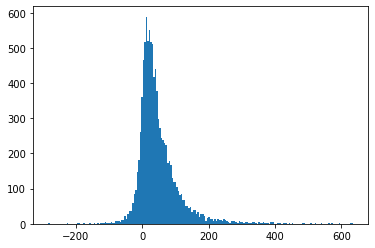

{1: -50.49,
 5: -15.3,
 10: -3.76,
 20: 7.35,
 30: 15.48,
 40: 24.12,
 50: 33.04,
 60: 43.58,
 70: 58.67,
 80: 79.43,
 90: 116.6,
 95: 159.59,
 99: 285.26}
-
76.97% chance masking is a good idea


In [4]:
n_samples = 10*K

print('## CONCERT ##')
p_covid_infection_g_mask = sq.to(110/M, 970/M) # https://www.microcovid.org/?distance=close&duration=120&interaction=oneTime&personCount=15&riskProfile=average&scenarioName=custom&setting=indoor&subLocation=US_39061&theirMask=none&topLocation=US_39&voice=silent&yourMask=n95&yourVaccineDoses=3&yourVaccineType=moderna
p_covid_infection_g_no_mask = sq.to(320/M, 2900/M) # https://www.microcovid.org/?distance=close&duration=120&interaction=oneTime&personCount=15&riskProfile=average&scenarioName=custom&setting=indoor&subLocation=US_39061&theirMask=none&topLocation=US_39&voice=silent&yourMask=none&yourVaccineDoses=3&yourVaccineType=moderna
samples = sq.sample(value_lost_from_covid(p_covid_infection_g_no_mask - p_covid_infection_g_mask), n=n_samples, verbose=True)

print('-')
print('Mean: {}, SD: {}'.format(round(np.mean(samples), 2),
                                round(np.std(samples), 2)))
print('-')
hist(samples)
pprint(sq.get_percentiles(samples, digits=2))

print('-')
willingness_to_pay_to_avoid_masking = 10
print('{}% chance masking is a good idea'.format(sum([s > willingness_to_pay_to_avoid_masking for s in samples]) / n_samples * 100))



## AIRPLANE ##


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 14500.48it/s]


-
Mean: 2.5, SD: 3.18
-


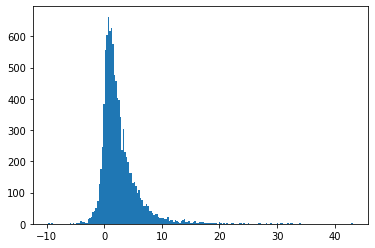

{1: -2.08,
 5: -0.64,
 10: -0.1,
 20: 0.41,
 30: 0.82,
 40: 1.24,
 50: 1.7,
 60: 2.28,
 70: 3.02,
 80: 4.09,
 90: 5.98,
 95: 8.06,
 99: 14.63}
-
5.1% chance masking is a good idea


In [5]:
print('## AIRPLANE ##')
p_covid_infection_g_mask = sq.to(5.4/M, 48/M) # https://www.microcovid.org/?distance=normal&duration=180&interaction=oneTime&personCount=6&riskProfile=average&scenarioName=custom&setting=plane&subLocation=US_39061&theirMask=none&theirVaccine=vaccinated&topLocation=US_39&voice=silent&yourMask=n95&yourVaccineDoses=3&yourVaccineType=moderna
p_covid_infection_g_no_mask = sq.to(16/M, 150/M) # https://www.microcovid.org/?distance=normal&duration=180&interaction=oneTime&personCount=6&riskProfile=average&scenarioName=custom&setting=plane&subLocation=US_39061&theirMask=none&theirVaccine=vaccinated&topLocation=US_39&voice=silent&yourMask=none&yourVaccineDoses=3&yourVaccineType=moderna
samples = sq.sample(value_lost_from_covid(p_covid_infection_g_no_mask - p_covid_infection_g_mask), n=n_samples, verbose=True)

print('-')
print('Mean: {}, SD: {}'.format(round(np.mean(samples), 2),
                                round(np.std(samples), 2)))
print('-')
hist(samples)
pprint(sq.get_percentiles(samples, digits=2))

print('-')
willingness_to_pay_to_avoid_masking = 8
print('{}% chance masking is a good idea'.format(sum([s > willingness_to_pay_to_avoid_masking for s in samples]) / n_samples * 100))



## 15MIN IN STORE ##


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 15181.39it/s]


-
Mean: 0.02, SD: 0.02
-


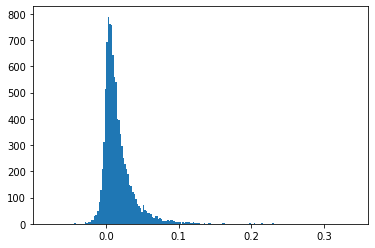

{1: -0.01,
 5: -0.0,
 10: -0.0,
 20: 0.0,
 30: 0.0,
 40: 0.01,
 50: 0.01,
 60: 0.01,
 70: 0.02,
 80: 0.03,
 90: 0.04,
 95: 0.06,
 99: 0.1}
-
0.0% chance masking is a good idea


In [6]:
print('## 15MIN IN STORE ##')
p_covid_infection_g_no_mask = sq.to(0.1/M, 1/M) # https://www.microcovid.org/?distance=sixFt&duration=15&interaction=oneTime&personCount=1&riskProfile=average&scenarioName=custom&setting=plane&subLocation=US_39061&theirMask=none&theirVaccine=vaccinated&topLocation=US_39&voice=silent&yourMask=none&yourVaccineDoses=3&yourVaccineType=moderna
p_covid_infection_g_mask = sq.to(0.04/M, 0.3/M) # https://www.microcovid.org/?distance=sixFt&duration=15&interaction=oneTime&personCount=1&riskProfile=average&scenarioName=custom&setting=plane&subLocation=US_39061&theirMask=none&theirVaccine=vaccinated&topLocation=US_39&voice=silent&yourMask=none&yourVaccineDoses=3&yourVaccineType=moderna
samples = sq.sample(value_lost_from_covid(p_covid_infection_g_no_mask - p_covid_infection_g_mask), n=n_samples, verbose=True)

print('-')
print('Mean: {}, SD: {}'.format(round(np.mean(samples), 2),
                                round(np.std(samples), 2)))
print('-')
hist(samples)
pprint(sq.get_percentiles(samples, digits=2))

print('-')
willingness_to_pay_to_avoid_masking = 0.50
print('{}% chance masking is a good idea'.format(sum([s > willingness_to_pay_to_avoid_masking for s in samples]) / n_samples * 100))

